<a href="https://colab.research.google.com/github/debatelab/genai-epistemology/blob/main/notebooks/bounded_confidence_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Epistemic Communities <br>with LLM-based Agents

*Author: Gregor Betz (Debatelab@KIT)*

Example notebook with illustrative  numerical (classic) and natural-language (🔥LLM-based) implementations of the Hegselmann-Krause aka Bounded Confidence Model.

## Setup

In [ ]:
# to avoid trouble with accelerate on latest NVIDIA Pytorch containers:
#%pip uninstall transformer_engine -y

In [ ]:
# to avoid trouble with accelerate on latest NVIDIA Pytorch containers:
#%pip uninstall transformer_engine -y

#clone repo to get requirements:
!git clone https://github.com/debatelab/genai-epistemology
%cd genai-epistemology
# install requirements (see this notebook's folder)
%pip install -r notebooks/requirements.txt

In [2]:
!nvidia-smi

Thu Nov 30 13:42:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:31:00.0 Off |                    0 |
| N/A   44C    P0              54W / 400W |     22MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# Imports

import copy
import random
import uuid

from IPython.display import Markdown, display
import lmql
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Skeleton BC Model

We define a **class** of bounded confidence models by setting up an **abstract** bounded confidence agent that can be instantiated by different kinds of specific agents (numerical, or natural-language based) later on.

Specific bounded confidence agents may differ:

1. regarding the way their `opinion` is represented
2. in the way they assess the (numerical) distance between their own and another `opinion`
3. in the way they revise their own `opinion` given the views of their peers  

In [8]:
class AbstractBCAgent():

    def __init__(self, initial_opinion, **kwargs):
        self.opinion = initial_opinion
        self._step = 0
        self._distances = {}
        self._parameters = kwargs
        self.uid = str(uuid.uuid4())

    async def update(self, community):
        """updates agent state"""
        peers = await self.peers(community)
        opinions = [peer.opinion for peer in peers]
        if opinions:
            self.opinion = await self.revise(opinions)
        self._step += 1

    async def peers(self, community):
        """returns agents with opinion distance smaller than epsilon"""
        epsilon = self._parameters.get("epsilon", .1)
        self._distances = {
            agent.uid: await self.distance(agent.opinion)
            for agent in community if agent.uid != self.uid
        }
        print(self._distances)
        peers = [
            agent for agent in community
            if self._distances.get(agent.uid,1) <= epsilon and
            agent.uid != self.uid
        ]
        return peers

    def distance(self, opinion):
        """calculates distance between agent's and other opinion"""

    def revise(self, opinions):
        """revises agent's opinion given opinions (of peers)"""

    def log_state(self):
        """agent state for logging"""
        return {"uid": self.uid, "opinion": self.opinion, "distances": self._distances}


In [9]:
class EpistemicCommunity():

    def __init__(self, agents: list[AbstractBCAgent]):
        self.agents = agents
        self.logs = []
        self.log(0)

    async def interact(self, max_steps=10):
        for step in tqdm(range(max_steps), "STEP"):
            agents_snapshot = copy.deepcopy(self.agents)
            for agent in self.agents:
                await agent.update(agents_snapshot)
            self.log(step+1)

    def log(self, step):
        self.logs.append({
            "step": step,
            "agents": [agent.log_state() for agent in self.agents]
        })

    @property
    def config(self):
        agents = []
        for agent in self.agents:
            agent_config = agent._parameters.copy()
            agent_config["uid"] = agent.uid
            agents.append(agent_config)
        return {
            "agents": agents
        }
    
    def to_json(self, path):
        import json
        config = self.config.copy()
        for k,v in config.items():
            try:
                json.dumps(v)
            except TypeError:
                config[k] = str(v)
        data = {
            "logs": self.logs,
            "config": config
        }
        with open(path, "w") as f:
            json.dump(data, f)

## Exploration and Visualization Helpers

In [264]:
class Rainer():
    """data exploration and visualization"""

    def __init__(self, logs, config=None):
        self.logs = logs
        df = pd.DataFrame(logs).explode(["agents"])
        df = pd.concat([
            df.step,
            df.agents.apply(pd.Series)
        ], axis=1)        
        self.df = df
        self.config = config

    @staticmethod
    def from_json(path):
        with open(path, "r") as f:
            import json
            data = json.load(f)
            logs = data["logs"]
            config = data.get("config",None)
            return Rainer(logs, config)

    def plot_opinion_evolution(self):
        """opinion evolution"""
        if self.df.opinion.dtype != "float":
            print("⚠️ Cannot plot opinion evolution for non-numerical opinions.")
            return None
        return sns.lineplot(
            data=self.df,
            x="step",
            y="opinion",
            hue="uid",
            legend=False,
        )
    

    def diff_hist(self, step: int):
        """opinion distance histogram"""
        diffs = self.df[self.df.step.eq(step)].distances.apply(pd.Series).unstack().dropna().to_list()
        return sns.histplot(diffs)

    def get_diff_evolution(self, quantiles=[.1, .25, .5, .75, .9]):
        """opinion distance evolution"""
        data = []
        for i in self.df.step.unique().tolist()[:-1]:
            diffs = self.df[self.df.step.eq(i+1)].distances.apply(pd.Series).unstack().dropna().to_list()
            records = [
                {
                    "metric": f"Q{q:.2f}",
                    "diffs": np.quantile(diffs, q),
                    "step": i,
                }
                for q in quantiles 
            ]                
            records.append({"metric": "mean", "diffs": np.mean(diffs), "step": i})
            records.append({"metric": "median", "diffs": np.median(diffs), "step": i})
            records.append({"metric": "min", "diffs": np.min(diffs), "step": i})
            records.append({"metric": "max", "diffs": np.max(diffs), "step": i})

            data.extend(records)

        df_diff = pd.DataFrame(data)
        return df_diff

    def plot_diff_evolution(self, quantiles=[.1, .25, .5, .75, .9]):
        """opinion distance evolution"""
        df = self.get_diff_evolution(quantiles)
        metrics = [f"Q{q:.2f}" for q in quantiles]
        return sns.lineplot(
            data=df[df.metric.isin(metrics)],
            x="step",
            y="diffs",
            hue="metric",
            palette="flare",
            linewidth=2,
            style="metric",
            dashes=[(1,1),(2,2),(4,1),(2,2),(1,1)],
            markers=["P","X","o","X","P"],
        )
    
    def display_opinions(self, steps = None):
        """display opinions"""
        if steps is None:
            steps = self.df.step.unique().tolist()

        for step in steps:
            display(Markdown("------"))
            display(Markdown(f"### Opinions at step {step}"))
            lines = [
                f"* {o}" for o 
                in self.df[self.df.step.eq(step)].opinion
            ]
            display(Markdown("\n".join(lines)))
    
    @property
    def df_opinions(self):
        return self.df


## Numerical BC Model

We re-create a standard Bounded Confidence Model by implementing the abstract BC agent with numerical opinions, euclidean distance and weighted averaging as peer revision. 

In [227]:
class NumericalBCAgent(AbstractBCAgent):

    async def distance(self, opinion):
        """calculates distance between agent's and other opinion"""
        return abs(opinion - self.opinion)

    async def revise(self, opinions):
        """revision through weighted opinion averaging"""
        alpha = self._parameters.get("alpha", .5)
        revision = alpha * self.opinion + (1-alpha) * np.mean(opinions)
        return revision

Let's simulate a BC community with 23 agents (epsilon=.2; alpha=.5)!

In [ ]:
N = 23

community = EpistemicCommunity([
    NumericalBCAgent(
        random.random(),
        alpha=.5,
        epsilon=.2
    ) for _ in range(N)
])

await community.interact()

In [171]:
community.to_json("community.json")

### Inspection

In [173]:
rainer = Rainer.from_json("community.json")

<AxesSubplot:xlabel='step', ylabel='opinion'>

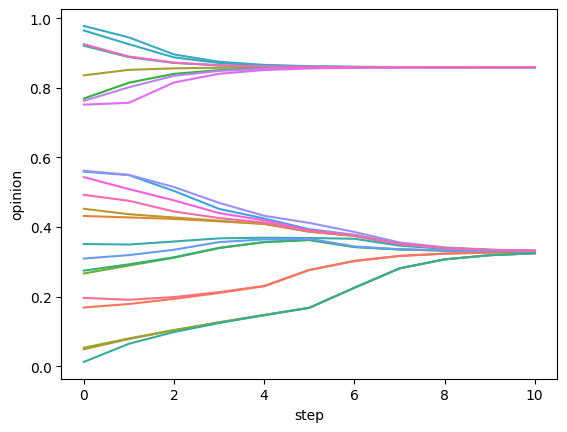

In [174]:
rainer.plot_opinion_evolution()

<AxesSubplot:ylabel='Count'>

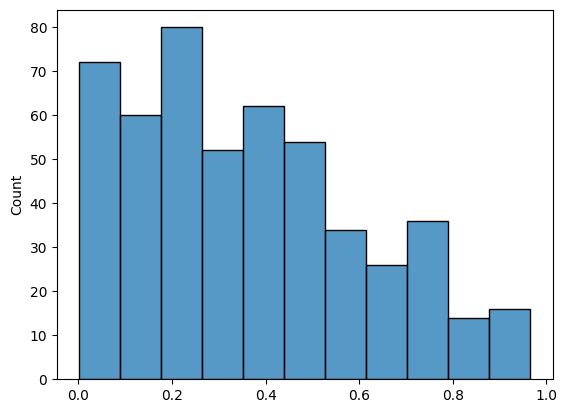

In [175]:
# distribution of pairwise opinion distances at step 1
rainer.diff_hist(1)

<AxesSubplot:xlabel='step', ylabel='diffs'>

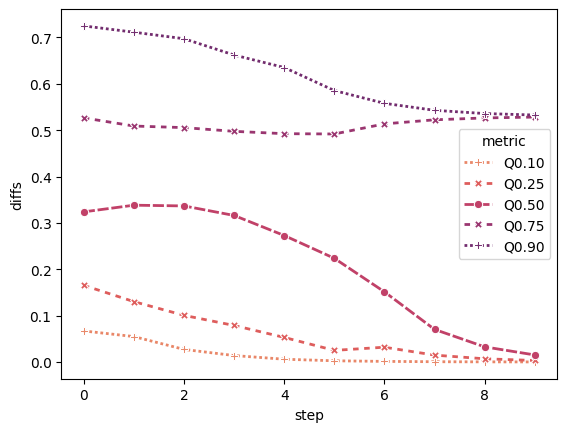

In [176]:
# quantiles of pairwise opinion distances over time
rainer.plot_diff_evolution()

## Natural-Language BC Model

### Large Language Model

Pick LLM which powers our AI agents (see https://huggingface.co/HuggingFaceH4/zephyr-7b-alpha):

In [4]:
model = lmql.model(
    "local:HuggingFaceH4/zephyr-7b-alpha",
    device_map = "auto",
    load_in_8bit=True,
    low_cpu_mem_usage=True
)


### Prompts

LMQL queries (i.e., prompt templates), used to simulate agent actions (see https://lmql.ai).

In [5]:
# Prompt template used to determine whether own opinion is similar to other opinions

@lmql.query
async def agreement_lmq(own, other, topic):
    '''lmql
    argmax
      "<|user|>\n"
      "# Assess perceived expertise\n\n"
      "Suppose Alice and Bob are debating '{topic}'.\n"
      "They hold the following opinions.\n\n"
      "Alice: {own}\n\n"
      "Bob: {other}\n\n"
      "Given these opinions, is Alice prepared to listen to what Bob has to say and take "
      "his view into account when revising her beliefs?\n"
      "To address this question, let's assess how similar Bob's and Alice's opinions are:"
      "(A) very similiar\n"
      "(B) somewhat similar\n"
      "(C) neither similar nor opposing\n"
      "(D) somewhat opposing\n"
      "(E) strongly opposing\n"
      "Just answer with A/B/C/D/E (you'll be asked to explain your answer later on)."
      "<|assistant|>\n"
      "[LABEL]"
    distribution
      LABEL in ["A","B","C","D","E"]
    '''

# Example:
# >>> agreement_lmq("It's irresponsible to eat meat.", "A cheese cake from time to time is fine.", "veganism")
# >>> [('A', 0.0034), ('B', 0.2116), ('C', 0.7330), ('D', 0.0091), ('E', 0.0426)]



# Prompt template used to revise own opinion given peer opinions

@lmql.query
async def revise_lmq(opinion, peer_opinions, self_confidence, topic):
    '''lmql
    sample(temperature=0.6)
      "<|user|>\n"
      "# Consider whether and how to revise your opinion\n\n"
      "You have been debating '{topic}'.\n"
      "You have previously held the following opinion.\n\n"
      "Your previous opinion: \"{opinion}\"\n\n"
      "Now, through debating '{topic}', you have learned that your peers maintain the following views:\n"
      for peer_opinion in peer_opinions:
        "- {peer_opinion}\n"
      "\n"
      "You consider your peers trustworthy and reliable.\n"
      "You have {self_confidence} confidence in your previously held opinion and accordingly {self_confidence} resistance to changing your opinion.\n\n"
      "This being said, which opinion will you adopt in the future, having heard about your peers' views?\n"
      "1. Repeat your previously held opinion.\n"
      "2. State your future opinion in a single sentence, keeping it short and concise.\n"
      "<|assistant|>\n"
      "1. My previous opinion: \"{opinion}\"\n"
      "2. My future opinion: \"[REVISION]" where STOPS_AT(REVISION, ".") and STOPS_AT(REVISION, "!") and STOPS_AT(REVISION, '"') and len(REVISION)<240
      return REVISION.strip('"')
    '''


# Prompt template for sampling initial opinions (not used by agents, but to init community)

@lmql.query
async def init_lmq(stance, topic, n=1):
    '''lmql
    sample(temperature=0.9)
      "<|user|>\n"
      "# Provide a claim that corresponds to a given stance\n\n"
      "Alice is going to debate '{topic}'.\n"
      "For the purpose of the debate, she'll initially adopt a claim that is {stance} {topic}.\n\n"
      "Can you please suggest {n} such claims?\n\n"
      "State each claim in a single sentence, keeping it short and concise. "
      "Make sure you provide sufficiently diverse claims.\n"
      "<|assistant|>\n"
      "Alice might defend one of the following claims:\n"
      claims = []
      for _ in range(n):
        "  * \"[OPINION]\"\n" where STOPS_AT(OPINION, ".") and STOPS_AT(OPINION, "!") and STOPS_AT(OPINION, '"') and len(OPINION)<220
        claims.append(OPINION)
      return claims
    '''



### LLM-based Natural Language BC Agent

In [9]:
class NaturalLanguageBCAgent(AbstractBCAgent):

    async def distance(self, other):
        """distance as expected agreement level"""
        lmql_result = await agreement_lmq(
            self.opinion,
            other,
            topic=self._parameters.get("topic", "veganism"),
            model=self._parameters["model"]
        )
        probs = lmql_result.variables.get("P(LABEL)")
        return sum([i*v for i, (_, v) in enumerate(probs)])/4.0

    async def revise(self, opinions):
        """natural language opinion revision"""
        revision = await revise_lmq(
            opinion=self.opinion,
            peer_opinions=opinions,
            self_confidence=self._parameters.get("self_confidence", "average"),
            topic=self._parameters.get("topic", "veganism"),
            model=self._parameters["model"]
        )
        return revision

### Simulation

We initialize an epistemic community of 10 agents with diverse initial opinions. 

In [11]:
# for initializing agents
parameters = {
    "model": model,
    "self_confidence": "very high",
    "topic": "veganism",
    "epsilon": .5,
}

# for sampling initial positions
initial_stances = [
    "fully affirming",
    "vehemently against",
    "loosely related to",
    "vaguely putting in doubt",
    "based on (positive or negative) personal experience regarding"
]

# initial opinions to generate for each stance
agents_per_stance = 2

# number of agents
print(f"Generating community with {agents_per_stance*len(initial_stances)} agents.")

Generating community with 10 agents.


In [179]:
# Sample initial positions for agents

initial_opinions = []

for stance in tqdm(initial_stances):

    claims = await init_lmq(
        topic=parameters["topic"],
        stance=stance,
        n=agents_per_stance,
        model=model
    )
    initial_opinions.extend(claims)

initial_opinions

100%|█████████████████████████████████████████████| 5/5 [01:04<00:00, 12.92s/it]


['Consuming a vegan diet directly contributes to reducing greenhouse gas emissions, as animal agriculture is a significant source of environmental pollution.',
 'The scientific evidence supports the health benefits of a vegan diet, which can lead to a reduced risk of various diseases, such as diabetes, high blood pressure, and some cancers.',
 "Veganism doesn't support a healthy and balanced diet.",
 'There is a negative impact on the environment and economy when people follow a vegan diet.',
 'A vegan diet can prevent certain types of cancer.',
 'Reducing meat consumption is necessary to avoid a global food crisis.',
 'Contrary to popular belief, studies suggest that a well-planned traditional omnivorous diet may reduce the risk of certain diseases compared to a vegan diet.',
 'While plant-based diets have their benefits, they are not always easy to stick to in the long run.',
 'As someone who has been vegan for over a year, my energy levels have increased significantly while my risk 

In [252]:
# Initialize agents and epistemic community

community = EpistemicCommunity([
    NaturalLanguageBCAgent(io,**parameters)
    for io in initial_opinions
])

We let agents interact for 5 steps.

In [ ]:
await community.interact(5)

In [254]:
# Save results
community.to_json("work/data/veganism_very-high_50-001.json")

### Inspection

<AxesSubplot:xlabel='step', ylabel='diffs'>

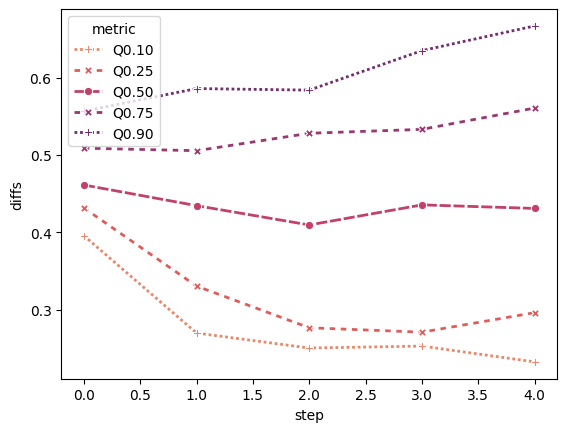

In [269]:
rainer = Rainer.from_json("work/data/veganism_very-high_40-001.json")
rainer.plot_diff_evolution()

<AxesSubplot:xlabel='step', ylabel='diffs'>

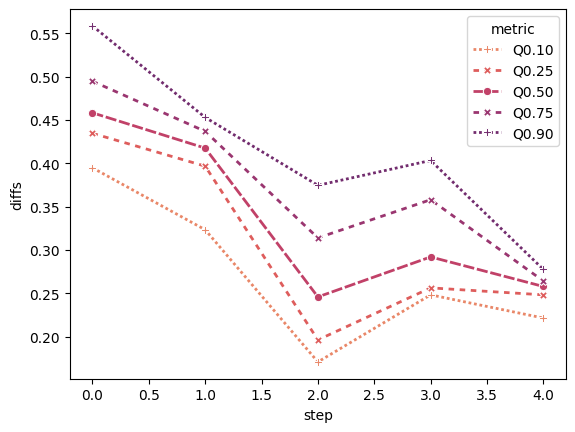

In [266]:
rainer = Rainer.from_json("work/data/veganism_very-high_50-001.json")
rainer.plot_diff_evolution()

In [267]:
rainer.display_opinions([5])

------

### Opinions at step 5

* Veganism can be a sustainable and healthy lifestyle choice for many individuals, but it's crucial to ensure a balanced and nutrient-rich diet, consider the environmental impact, and address potential challenges in the long term.
* A well-planned vegan diet, ensuring a balanced and nutrient-rich diet, considering the environmental impact, and addressing potential challenges in the long term, can be a sustainable and healthy lifestyle choice for many individuals.
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's essential to ensure a balanced and nutrient-rich diet, consider potential challenges in the long term, and address environmental and
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's essential to ensure a balanced and nutrient-rich diet and consider the environmental impact and potential challenges in the long-run
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's essential to ensure a balanced and nutrient-rich diet, consider the environmental impact, and address potential challenges in the
* A balanced and nutrient-rich vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's crucial to consider the environmental impact and address potential challenges in the long term.
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's essential to ensure a balanced and nutrient-rich diet, consider its environmental impact, and address potential challenges in the
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's essential to ensure a balanced and nutrient-rich diet, consider the environmental impact, and address potential challenges in the, a
* A balanced and nutrient-rich vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's crucial to consider the environmental impact, address potential challenges in the long term, and ensure a balanced and
* A well-planned vegan diet can be a sustainable and healthy lifestyle choice for many individuals, but it's crucial to ensure a balanced and nutrient-rich diet, consider the environmental impact, and address potential challenges in the long

## Backup 

Test LMQL queries:

In [6]:
lmql_result = await agreement_lmq(
    "It's outright irresponsible to eat meat.",
    "I think it's ok to eat a nice cheese cake from time to time.",
    topic="veganism",
    model=model
)
probs = lmql_result.variables.get("P(LABEL)")
print(probs)
sum([i*v for i, (_, v) in enumerate(probs)])/4.0

[Loading HuggingFaceH4/zephyr-7b-alpha with AutoModelForCausalLM.from_pretrained("HuggingFaceH4/zephyr-7b-alpha", device_map=auto, load_in_8bit=True, low_cpu_mem_usage=True)]]


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

[HuggingFaceH4/zephyr-7b-alpha ready on device cuda:0]
CompletedProcess(args=['pip', 'show', 'bitsandbytes'], returncode=0, stdout=b'Name: bitsandbytes\nVersion: 0.41.2.post2\nSummary: k-bit optimizers and matrix multiplication routines.\nHome-page: https://github.com/TimDettmers/bitsandbytes\nAuthor: Tim Dettmers\nAuthor-email: dettmers@cs.washington.edu\nLicense: MIT\nLocation: /usr/local/lib/python3.10/dist-packages\nRequires: \nRequired-by: \n', stderr=b'')
[('A', 0.003448180284938632), ('B', 0.21167120231390887), ('C', 0.7330556634675195), ('D', 0.009155997584275483), ('E', 0.04266895634935743)]


0.468981586849801

In [ ]:
async def numagree(own, other):
    lmql_result = await agreement(
        own,
        other,
        topic="veganism",
        model=model
    )
    probs = lmql_result.variables.get("P(LABEL)")
    return sum([i*v for i, (_, v) in enumerate(probs)])/4.0

await numagree(
    "It's outright irresponsible to eat meat.",
    "I think it's ok to eat a nice cheese cake from time to time.",
)

0.468981586849801

In [ ]:
result = await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I think it's ok to eat a nice burger every day.",
        "I think it's ok to eat a nice cheese cake from time to time.",
    ],
    topic="veganism",
    self_confidence="low",
    model=model
)
print(result)

While I still believe that eating meat is a contributing factor to environmental degradation and animal cruelty, I acknowledge that moderation in consumption is a personal choice and should be respected.


In [ ]:
await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I never eat meat, not even dietary products.",
        "I think it's ok to eat a nice cheese cake from time to time.",
        "It's outright irresponsible to eat meat.",
        "It's outright irresponsible to eat meat.",
    ],
    topic="veganism",
    self_confidence="extremely high",
    model=model
)

'While I still believe that consuming meat is irresponsible due to its environmental impact and animal welfare concerns, I recognize that personal choices differ and respect those who choose to consume animal products in moderation.'

In [ ]:
await init(
    topic="veganism",
    stance="vaguely putting in doubt",
    n=5,
    model=model
)

['Studies have shown that vegans may have a higher risk of certain nutrient deficiencies than those who consume animal products.',
 'A balanced, omnivorous diet is best for human health because it provides a complete set of nutrients that cannot always be obtained through vegan options.',
 'The environmental impact of raising animals for food is not as severe as once thought, and some experts suggest that consuming a moderate amount of meat can be acceptable for environmental reasons.',
 'There is evidence from multiple medical studies that a diet containing animal products can actually protect against certain chronic diseases, including heart disease and type 2 diabetes.',
 'The consumption of animal products has been a part of the human diet for thousands of years and has likely contributed to our advanced cognitive development, unlike the diets of purely plant-based animals.']

In [ ]:
await init(
    topic="veganism",
    stance="based on (positive) personal experience regarding",
    n=3,
    model=model
)

['I noticed significant improvements in my overall health, including a decrease in weight, cholesterol, and inflammation, after adopting a vegan diet.',
 'As a long-time vegan, I have never experienced a nutrient deficiency and have been able to maintain a balanced diet without consuming animal products.',
 'I can confidently say that since switching to a vegan lifestyle, I have reduced pollution, greenhouse gas emissions, and water consumption while also supporting environmentally sustainable farming practices.']